# Get clinical trial info for drugs in Tahoe dataset

In [1]:
# Autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install huggingface
# !pip install datasets

In [3]:
import requests
import pandas as pd
import json
import time
from typing import List, Dict, Any, Union, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from drug_trials_extractor import DrugTrialExtractor
from drug_trials_extractor import standardize_medical_conditions

In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset

ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")
cs = load_dataset("tahoebio/Tahoe-100M", "cell_line_metadata")

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Convert the dataset to a pandas DataFrame and display it
drug_metadata = ds["train"].to_pandas()
cell_line_metadata = cs['train'].to_pandas()
drug_metadata.head()

,drug,targets,moa-broad,moa-fine,human-approved,clinical-trials,gpt-notes-approval,canonical_smiles,pubchem_cid
0,Talc,None,unclear,unclear,yes,yes,Talc used in pharma and cosmetics; safety unde...,[OH-].[OH-].[O-][Si]12O[Si]3(O[Si](O1)(O[Si](O...,165411828.0
1,Bortezomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma and mantle cell ...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,387447.0
2,Ixazomib,PSMB5,inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment.,B(C(CC(C)C)NC(=O)CNC(=O)C1=C(C=CC(=C1)Cl)Cl)(O)O,25183872.0
3,Ixazomib citrate,"PSMB1, PSMB2, PSMB5",inhibitor/antagonist,Proteasome inhibitor,yes,yes,Approved for multiple myeloma treatment as par...,B1(OC(=O)C(O1)(CC(=O)O)CC(=O)O)C(CC(C)C)NC(=O)...,56844015.0
4,Lactate (calcium),None,unclear,unclear,yes,yes,"Used in medical settings, but not specifically...",C.CC(C(=O)[O-])O.[Ca+2],168311648.0


In [6]:
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]
all_pubchem_ids = drug_metadata['pubchem_cid_str'][drug_metadata['pubchem_cid_str'] != 'nan'].unique().tolist()

### Get clinical trials data

In [56]:
# Create an instance of the DrugTrialExtractor
extractor = DrugTrialExtractor()

In [65]:
results = extractor.process_multiple_drugs(all_pubchem_ids, max_results_per_drug=500)
output_files = extractor.save_results_to_csv(results, output_prefix="tahoe_drugs")

Processing PubChem ID: 165411828
Searching ClinicalTrials.gov for common name: STERITALC
Searching ClinicalTrials.gov for synonym: STERITALC
Processing PubChem ID: 387447
Searching ClinicalTrials.gov for common name: DPBA
Searching ClinicalTrials.gov for synonym: Bortezomib
Processing PubChem ID: 25183872
Searching ClinicalTrials.gov for common name: Ixazomib
Searching ClinicalTrials.gov for synonym: Ixazomib
Searching ClinicalTrials.gov for synonym: MLN 2238
Searching ClinicalTrials.gov for synonym: 71050168A2
Processing PubChem ID: 56844015
Searching ClinicalTrials.gov for common name: NINLARO
Searching ClinicalTrials.gov for synonym: NINLARO
Searching ClinicalTrials.gov for synonym: mln9708
Searching ClinicalTrials.gov for synonym: 46CWK97Z3K
Processing PubChem ID: 168311648
Searching ClinicalTrials.gov for common name: Lactate (calcium)
Processing PubChem ID: 168312271
Searching ClinicalTrials.gov for common name: Bisoprolol (hemifumarate)
Processing PubChem ID: 444972
Searching Cl

In [7]:
trials_df = pd.read_csv('tahoe_drugs_clinical_trials.csv')

<Axes: xlabel='pubchem_id', ylabel='conditions'>

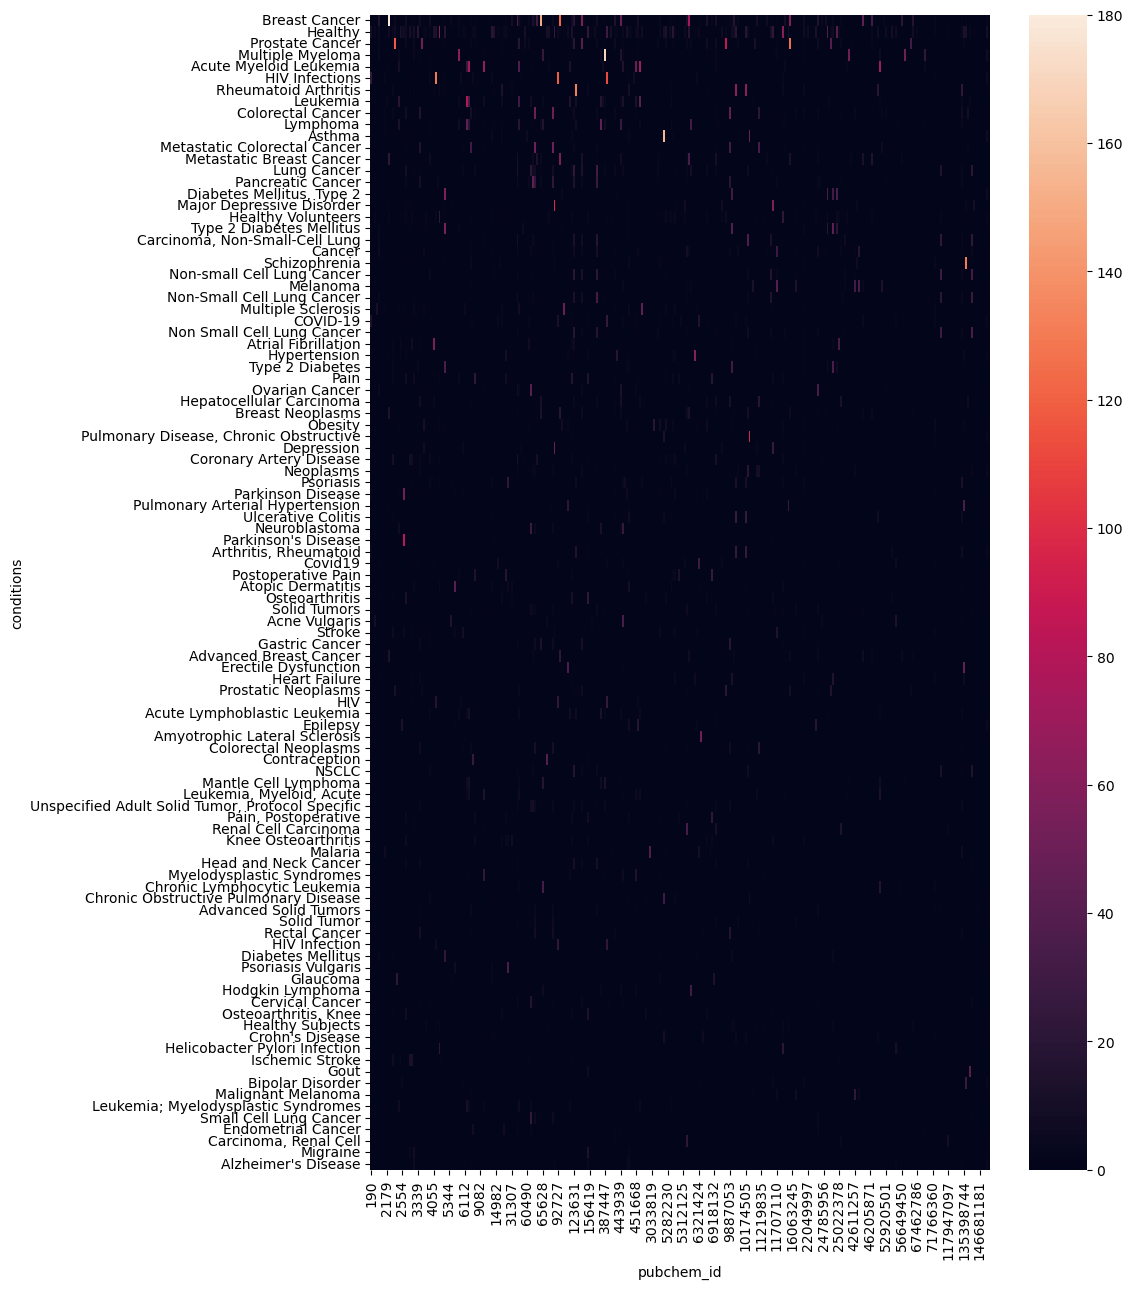

In [8]:
# Count the number of conditions in trials for each drug
condition_counts = trials_df.groupby(['pubchem_id', 'conditions']).size().reset_index()
condition_counts = condition_counts.pivot(index='conditions', columns='pubchem_id', values=0).fillna(0)
plt.figure(figsize=(10,15))
sns.heatmap(condition_counts.loc[condition_counts.sum(1).sort_values(ascending=False)[0:100].index], yticklabels=True)

In [ ]:
len(all_pubchem_ids)


376

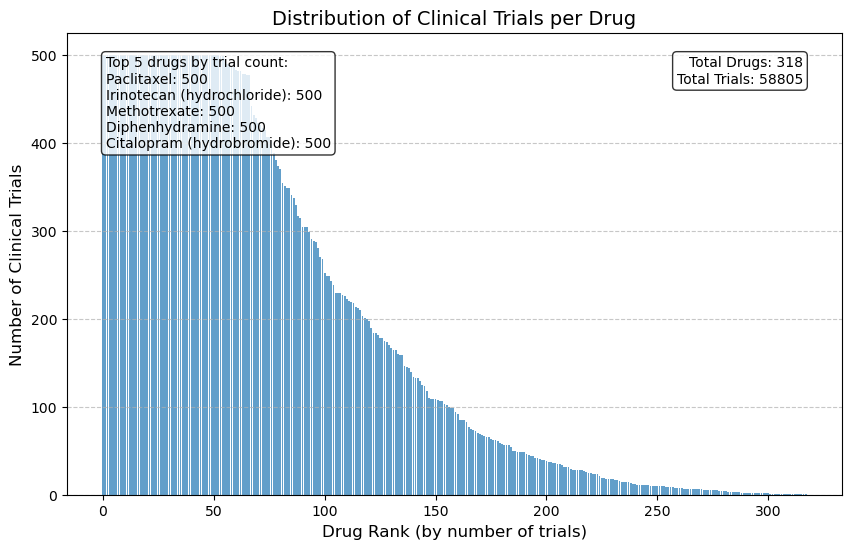

In [27]:
# Create a more informative plot of trials per drug
trial_counts = trials_df['pubchem_id'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(trial_counts)), trial_counts.values, alpha=0.7)
plt.xlabel('Drug Rank (by number of trials)', fontsize=12)
plt.ylabel('Number of Clinical Trials', fontsize=12)
plt.title('Distribution of Clinical Trials per Drug', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text showing total drugs and trials
plt.text(0.95, 0.95, f'Total Drugs: {len(trial_counts)}\nTotal Trials: {len(trials_df)}', 
         transform=plt.gca().transAxes, ha='right', va='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Show the top 5 drugs with most trials
if len(trial_counts) >= 5:
    top_drugs = trial_counts.head(5)
    top_drug_ids = top_drugs.index.tolist()
    top_drug_names = [drug_metadata.loc[drug_metadata['pubchem_cid_str'] == str(drug_id), 'drug'].values[0] 
                      if str(drug_id) in drug_metadata['pubchem_cid_str'].values else f"ID: {drug_id}" 
                      for drug_id in top_drug_ids]
    
    plt.text(0.05, 0.95, 'Top 5 drugs by trial count:\n' + '\n'.join([f"{name}: {count}" for name, count in zip(top_drug_names, top_drugs)]),
             transform=plt.gca().transAxes, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [9]:
from drug_trials_extractor import standardize_medical_conditions

In [45]:
condition_counts = trials_df.groupby(['pubchem_id', 'conditions']).size().reset_index()
condition_counts = condition_counts.pivot(index='conditions', columns='pubchem_id', values=0).fillna(0)
condition_counts_tot = condition_counts.sum(1).sort_values(ascending=False)
condition_counts_tot = condition_counts_tot[condition_counts_tot >= 3]
condition_counts_tot.head()

conditions
Breast Cancer             1253.0
Healthy                   1021.0
Prostate Cancer            698.0
Multiple Myeloma           493.0
Acute Myeloid Leukemia     485.0
dtype: float64

In [46]:
std_conditions = standardize_medical_conditions(condition_counts_tot.index.tolist())

In [58]:
std_conditions.to_csv("trial_conditions_standardized.csv")

In [10]:
std_conditions = pd.read_csv("trial_conditions_standardized.csv", index_col=0)

In [11]:
trials_df['standardized_condition'] = trials_df['conditions'].map(std_conditions.set_index('Original')['Standardized']).fillna(trials_df['conditions'])
trials_df

,nct_id,title,status,phase,conditions,interventions,pubchem_id,drug_name,standardized_condition
0,NCT04010565,Effect of a Black Garlic Extract on Cholestero...,COMPLETED,NaN,Cardiovascular Diseases,Aged black garlic extract (DIETARY_SUPPLEMENT)...,165411828,STERITALC,Cardiovascular Diseases
1,NCT00565266,Asthma Clinical Research Network (ACRN) Trial ...,COMPLETED,PHASE3,Asthma,tiotropium bromide (DRUG); salmeterol xinafoat...,165411828,STERITALC,Asthma
2,NCT04401579,Adaptive COVID-19 Treatment Trial 2 (ACTT-2),COMPLETED,PHASE3,COVID-19,Placebo (OTHER); Remdesivir (DRUG); Baricitini...,165411828,STERITALC,COVID-19
3,NCT05576038,Tryptophan for Impaired AhR Signaling in Celia...,RECRUITING,NaN,Tryptophan Metabolism Alterations; Celiac Disease,L-Tryptophan (DRUG); Freedom SimpleCap Powder ...,165411828,STERITALC,Tryptophan Metabolism Alterations; Celiac Disease
4,NCT06744946,Thoracoscopic Talc Pleurodesis Versus Bleomyci...,COMPLETED,PHASE4,Malignant Pleural Effusions (Mpe)- Pleurodesis...,thoracoscope (PROCEDURE),165411828,STERITALC,Malignant Pleural Effusions (Mpe)- Pleurodesis...
...,...,...,...,...,...,...,...,...,...
58800,NCT03387709,"UCSD Get Fit, Be Fit Study",COMPLETED,NaN,Overweight and Obesity,Pistachio-enriched diet (BEHAVIORAL); General ...,5282164,OZ,Overweight and Obesity
58801,NCT01084109,First Bites: Complementary Feeding - A Global ...,COMPLETED,PHASE3,Complementary Feeding; Infant Growth,Lyophilized meat (OTHER); Cereal (OTHER),5282164,OZ,Complementary Feeding; Infant Growth
58802,NCT04987307,Safety and Efficacy of Efavaleukin Alfa in Par...,TERMINATED,PHASE2,Ulcerative Colitis,Efavaleukin alfa (DRUG); Placebo (DRUG),5282164,OZ,Ulcerative Colitis
58803,NCT03990909,Pilot Study of BCAA on Sleep,RECRUITING,NaN,Sleep Disorder; Traumatic Brain Injury,Branched Chain Amino Acids (DIETARY_SUPPLEMENT...,5282164,OZ,Sleep Disorder; Traumatic Brain Injury


In [ ]:
# Get unique standardized conditions
unique_conditions = std_conditions.Standardized.unique()

# Save to a text file to pass to claude
with open('standardized_conditions.txt', 'w') as f:
    for condition in unique_conditions:
        f.write(f"{condition}\n")

array(['Breast Cancer', 'Healthy', 'Prostate Cancer', ...,
       'Parkinson Disease with Depression',
       'Left Atrial Appendage Closure',
       'Parkinsonian Signs in Older Persons'], dtype=object)

In [12]:
# Read the organ to conditions mapping file
import json

# Load the organ to conditions mapping from the JSON file
with open('organ_to_conditions_mapping.json', 'r') as f:
    organ_to_conditions = json.load(f)

# Display the list of organs
organ_list = list(organ_to_conditions.keys())
# Print the length of the list for each organ
for organ, conditions in organ_to_conditions.items():
    print(f"{organ}: {len(conditions)} conditions")
    
# Total count across all organs
print(f"\nTotal unique conditions: {len(sum(organ_to_conditions.values(), []))}")

# Create a mapping from condition to organ
condition_to_organ = {}

# Populate the mapping
for organ, conditions in organ_to_conditions.items():
    for condition in conditions:
        condition_to_organ[condition] = organ

# Function to find matching organ for a condition
def find_organ_for_condition(condition):
    # Check for direct match
    if condition in condition_to_organ:
        return condition_to_organ[condition]
    
    # Check if the condition contains any of the known conditions
    for known_condition, organ in condition_to_organ.items():
        if known_condition in condition:
            return organ
    
    # If no match found
    return None

# Apply the function to map conditions to organs
trials_df['matched_organ'] = trials_df['standardized_condition'].apply(find_organ_for_condition)

# Display the count of trials by organ
organ_counts = trials_df['matched_organ'].value_counts()
print("\nNumber of trials by organ:")
print(organ_counts)

# Calculate percentage of trials with matched organs
matched_count = trials_df['matched_organ'].notna().sum()
total_count = len(trials_df)
match_percentage = (matched_count / total_count) * 100

print(f"\nMatched {matched_count} out of {total_count} trials ({match_percentage:.2f}%)")

# Display the organs in the mapping
print("\nOrgans in the mapping:")
print(list(organ_to_conditions.keys()))



Bowel: 127 conditions
Lung: 186 conditions
Esophagus/Stomach: 62 conditions
Pancreas: 46 conditions
Skin: 78 conditions
Uterus: 26 conditions
Breast: 159 conditions
Ovary/Fallopian Tube: 36 conditions
Cervix: 6 conditions
CNS/Brain: 108 conditions
Liver: 86 conditions
Kidney: 74 conditions
Peripheral Nervous System: 12 conditions
Vulva/Vagina: 1 conditions
Bladder/Urinary Tract: 25 conditions

Total unique conditions: 1032

Number of trials by organ:
matched_organ
Lung                         4042
Breast                       3421
CNS/Brain                    2803
Bowel                        2268
Skin                         1722
Kidney                       1338
Liver                        1302
Esophagus/Stomach             757
Pancreas                      742
Ovary/Fallopian Tube          618
Bladder/Urinary Tract         344
Uterus                        291
Peripheral Nervous System     121
Cervix                        107
Vulva/Vagina                    3
Name: count, dtype: i

In [13]:
cell_line_metadata.Organ.unique()

array(['Lung', 'Vulva/Vagina', 'Skin', 'Breast', 'Bowel',
       'Esophagus/Stomach', 'Pancreas', 'Uterus', 'Bladder/Urinary Tract',
       'CNS/Brain', 'Liver', 'Ovary/Fallopian Tube', 'Cervix',
       'Peripheral Nervous System', 'Kidney'], dtype=object)

In [38]:
filt_trials_df = trials_df[~trials_df['matched_organ'].isna()]

# filt_trials_df[filt_trials_df.phase]['title'].tolist()

filt_trials_df = filt_trials_df[filt_trials_df.phase != 'Unknown'] # small pilot trials, diagnostic/prognostic trials
filt_trials_df = filt_trials_df[~filt_trials_df.phase.isna()] # small pilot trials, diagnostic/prognostic trials
filt_trials_df.to_csv('./data/drug_trials_matched.csv')

## Annotate success

Number of trials for each drug by organ:


/home/emmadann/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/emmadann/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/emmadann/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/emmadann/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


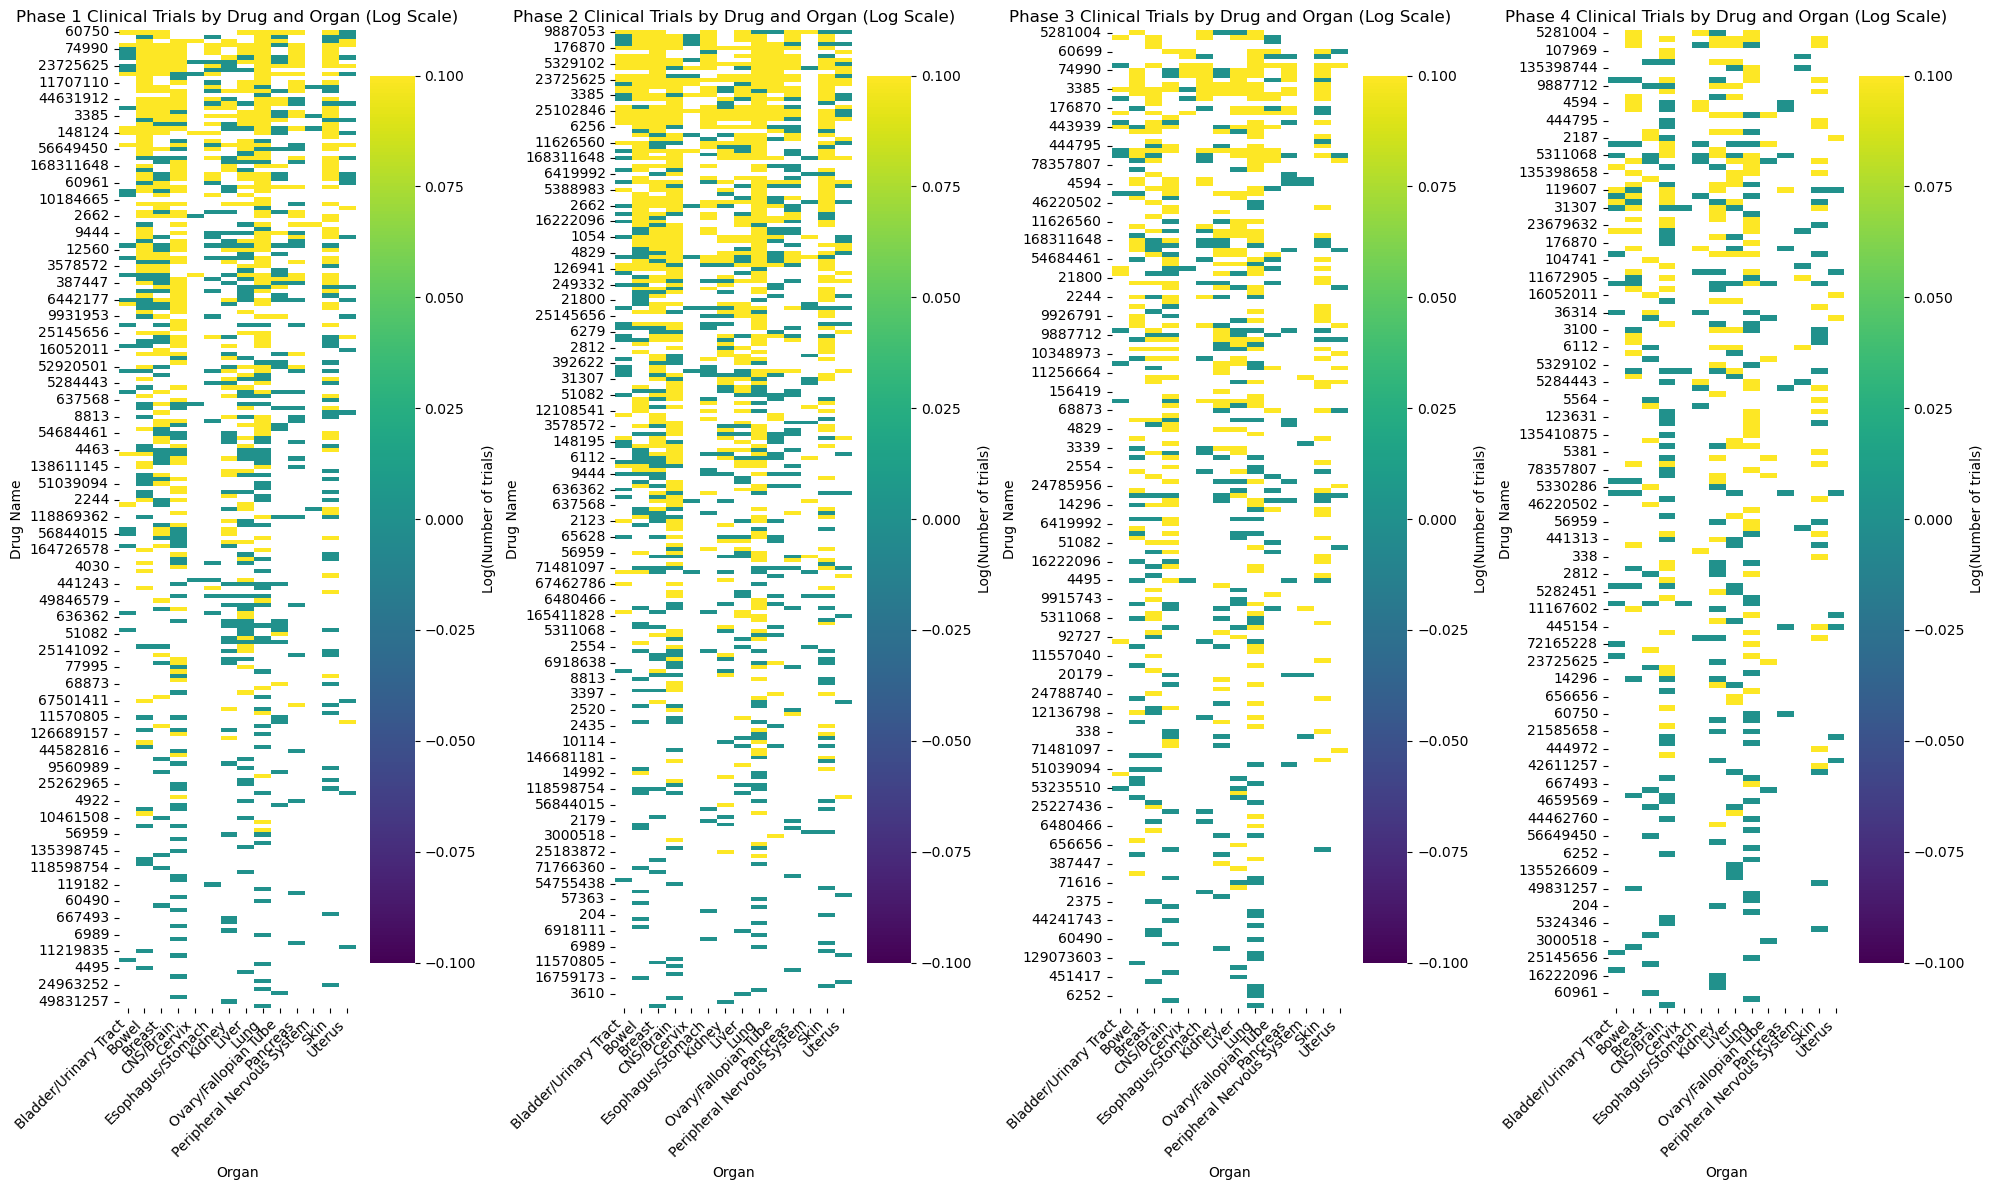

In [104]:
def create_drug_organ_matrix(trials_df, all_drugs=None):
    """
    Creates a matrix showing the number of trials for each drug by organ.
    
    Parameters:
    -----------
    trials_df : pandas.DataFrame
        DataFrame containing clinical trial data with 'drug_name' and 'matched_organ' columns
    all_drugs : list, optional
        List of all drug names to include in the matrix, even if they have no trials
    
    Returns:
    --------
    pandas.DataFrame
        A pivot table with drugs as rows, organs as columns, and trial counts as values
    """
    # Group by drug_name and matched_organ, then count the number of trials
    drug_organ_counts = trials_df.groupby(['pubchem_id', 'matched_organ']).size().reset_index(name='trial_count')

    # Pivot the table to show drugs as rows and organs as columns
    drug_organ_matrix = drug_organ_counts.pivot_table(
        index='pubchem_id', 
        columns='matched_organ', 
        values='trial_count',
        fill_value=0
    )

    # Add a total column
    drug_organ_matrix['Total'] = drug_organ_matrix.sum(axis=1)

    # If all_drugs is provided, ensure all drugs are included in the matrix
    if all_drugs is not None:
        # Get the current list of drugs in the matrix
        current_drugs = drug_organ_matrix.index.tolist()
        
        # Find drugs that are missing from the matrix
        missing_drugs = [drug for drug in all_drugs if drug not in current_drugs]
        print(len(missing_drugs))
        # Add missing drugs with zero counts
        for drug in missing_drugs:
            # Create a row of zeros for the drug
            zero_row = pd.Series(0, index=drug_organ_matrix.columns)
            # Add the row to the matrix
            drug_organ_matrix.loc[drug] = zero_row
        
        # Verify that the number of rows matches the expected number of drugs
        if len(drug_organ_matrix) != len(all_drugs):
            print(f"Warning: Matrix has {len(drug_organ_matrix)} rows but expected {len(all_drugs)} drugs")
            # Check for duplicates in the index
            duplicates = drug_organ_matrix.index.duplicated(keep=False)
            if any(duplicates):
                print(f"Found {sum(duplicates)} duplicate drug entries in the matrix")

    # Sort by total number of trials
    drug_organ_matrix = drug_organ_matrix.sort_values('Total', ascending=False)
    
    return drug_organ_matrix

# Create and display the drug-organ matrix
print("Number of trials for each drug by organ:")
# Create a figure with subplots for each phase in one row
fig, axes = plt.subplots(1, 4, figsize=(20, 12))
phases = ['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4']
# Get all drug names and organs to ensure consistent ordering across all heatmaps
all_drugs = sorted(filt_trials_df['drug_name'].unique())
all_organs = sorted(filt_trials_df['matched_organ'].unique())

# Plot heatmap for each phase
for i, phase in enumerate(phases):
    phase_df = filt_trials_df[filt_trials_df.phase == phase]
    drug_organ_matrix = create_drug_organ_matrix(phase_df)
    
    # Add log transformation to better visualize zeros and small values
    # Add a small constant (1) before log to handle zeros
    log_matrix = np.log10(drug_organ_matrix.drop(columns=['Total']))
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(log_matrix, 
                ax=axes[i], 
                cmap='viridis', 
                cbar_kws={'label': 'Log(Number of trials)'})
    
    axes[i].set_title(f'Phase {i+1} Clinical Trials by Drug and Organ (Log Scale)')
    axes[i].set_ylabel('Drug Name')
    axes[i].set_xlabel('Organ')
    
    # Rotate x-axis labels for better readability
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

In [95]:
len(all_pubchem_ids)

376

,nct_id,title,status,phase,conditions,interventions,pubchem_id,drug_name,standardized_condition,matched_organ
0,NCT04010565,Effect of a Black Garlic Extract on Cholestero...,COMPLETED,NaN,Cardiovascular Diseases,Aged black garlic extract (DIETARY_SUPPLEMENT)...,165411828,STERITALC,Cardiovascular Diseases,None
1,NCT00565266,Asthma Clinical Research Network (ACRN) Trial ...,COMPLETED,PHASE3,Asthma,tiotropium bromide (DRUG); salmeterol xinafoat...,165411828,STERITALC,Asthma,Lung
2,NCT04401579,Adaptive COVID-19 Treatment Trial 2 (ACTT-2),COMPLETED,PHASE3,COVID-19,Placebo (OTHER); Remdesivir (DRUG); Baricitini...,165411828,STERITALC,COVID-19,None
3,NCT05576038,Tryptophan for Impaired AhR Signaling in Celia...,RECRUITING,NaN,Tryptophan Metabolism Alterations; Celiac Disease,L-Tryptophan (DRUG); Freedom SimpleCap Powder ...,165411828,STERITALC,Tryptophan Metabolism Alterations; Celiac Disease,None
4,NCT06744946,Thoracoscopic Talc Pleurodesis Versus Bleomyci...,COMPLETED,PHASE4,Malignant Pleural Effusions (Mpe)- Pleurodesis...,thoracoscope (PROCEDURE),165411828,STERITALC,Malignant Pleural Effusions (Mpe)- Pleurodesis...,Lung
...,...,...,...,...,...,...,...,...,...,...
58800,NCT03387709,"UCSD Get Fit, Be Fit Study",COMPLETED,NaN,Overweight and Obesity,Pistachio-enriched diet (BEHAVIORAL); General ...,5282164,OZ,Overweight and Obesity,None
58801,NCT01084109,First Bites: Complementary Feeding - A Global ...,COMPLETED,PHASE3,Complementary Feeding; Infant Growth,Lyophilized meat (OTHER); Cereal (OTHER),5282164,OZ,Complementary Feeding; Infant Growth,None
58802,NCT04987307,Safety and Efficacy of Efavaleukin Alfa in Par...,TERMINATED,PHASE2,Ulcerative Colitis,Efavaleukin alfa (DRUG); Placebo (DRUG),5282164,OZ,Ulcerative Colitis,Bowel
58803,NCT03990909,Pilot Study of BCAA on Sleep,RECRUITING,NaN,Sleep Disorder; Traumatic Brain Injury,Branched Chain Amino Acids (DIETARY_SUPPLEMENT...,5282164,OZ,Sleep Disorder; Traumatic Brain Injury,CNS/Brain


In [121]:
trials_df

,nct_id,title,status,phase,conditions,interventions,pubchem_id,drug_name,standardized_condition,matched_organ
0,NCT04010565,Effect of a Black Garlic Extract on Cholestero...,COMPLETED,NaN,Cardiovascular Diseases,Aged black garlic extract (DIETARY_SUPPLEMENT)...,165411828,STERITALC,Cardiovascular Diseases,None
1,NCT00565266,Asthma Clinical Research Network (ACRN) Trial ...,COMPLETED,PHASE3,Asthma,tiotropium bromide (DRUG); salmeterol xinafoat...,165411828,STERITALC,Asthma,Lung
2,NCT04401579,Adaptive COVID-19 Treatment Trial 2 (ACTT-2),COMPLETED,PHASE3,COVID-19,Placebo (OTHER); Remdesivir (DRUG); Baricitini...,165411828,STERITALC,COVID-19,None
3,NCT05576038,Tryptophan for Impaired AhR Signaling in Celia...,RECRUITING,NaN,Tryptophan Metabolism Alterations; Celiac Disease,L-Tryptophan (DRUG); Freedom SimpleCap Powder ...,165411828,STERITALC,Tryptophan Metabolism Alterations; Celiac Disease,None
4,NCT06744946,Thoracoscopic Talc Pleurodesis Versus Bleomyci...,COMPLETED,PHASE4,Malignant Pleural Effusions (Mpe)- Pleurodesis...,thoracoscope (PROCEDURE),165411828,STERITALC,Malignant Pleural Effusions (Mpe)- Pleurodesis...,Lung
...,...,...,...,...,...,...,...,...,...,...
58800,NCT03387709,"UCSD Get Fit, Be Fit Study",COMPLETED,NaN,Overweight and Obesity,Pistachio-enriched diet (BEHAVIORAL); General ...,5282164,OZ,Overweight and Obesity,None
58801,NCT01084109,First Bites: Complementary Feeding - A Global ...,COMPLETED,PHASE3,Complementary Feeding; Infant Growth,Lyophilized meat (OTHER); Cereal (OTHER),5282164,OZ,Complementary Feeding; Infant Growth,None
58802,NCT04987307,Safety and Efficacy of Efavaleukin Alfa in Par...,TERMINATED,PHASE2,Ulcerative Colitis,Efavaleukin alfa (DRUG); Placebo (DRUG),5282164,OZ,Ulcerative Colitis,Bowel
58803,NCT03990909,Pilot Study of BCAA on Sleep,RECRUITING,NaN,Sleep Disorder; Traumatic Brain Injury,Branched Chain Amino Acids (DIETARY_SUPPLEMENT...,5282164,OZ,Sleep Disorder; Traumatic Brain Injury,CNS/Brain


In [110]:
create_drug_organ_matrix(phase_df, all_drugs=all_pubchem_ids)

376


matched_organ,Bladder/Urinary Tract,Bowel,Breast,CNS/Brain,Cervix,Esophagus/Stomach,Kidney,Liver,Lung,Ovary/Fallopian Tube,Pancreas,Peripheral Nervous System,Skin,Uterus,Total
pubchem_id,,,,,,,,,,,,,,,
5281004,0.0,6.0,0.0,0.0,0.0,3.0,1.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,82.0
16923,0.0,3.0,0.0,7.0,0.0,0.0,12.0,4.0,11.0,0.0,0.0,0.0,2.0,0.0,39.0
5284373,0.0,2.0,0.0,0.0,0.0,1.0,23.0,4.0,1.0,0.0,0.0,0.0,3.0,0.0,34.0
107969,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
24906252,0.0,0.0,1.0,1.0,0.0,0.0,24.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11957481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
filt_trials_df['pubchem_id'] = filt_trials_df.pubchem_id.astype(str)
phase_df = filt_trials_df[filt_trials_df.phase == 'PHASE4']

# Is the drug approved for any condition affecting the organ
success_df = create_drug_organ_matrix(phase_df, all_drugs=all_pubchem_ids).drop('Total', axis=1)
success_df = success_df.applymap(lambda x: 1 if x > 0 else 0)
success_df

# Has the drug ever been tested for a condition affecting the organ
tested_df = create_drug_organ_matrix(filt_trials_df, all_drugs=all_pubchem_ids).drop('Total', axis=1)
tested_df = tested_df.applymap(lambda x: 1 if x > 0 else 0)

208
98


/tmp/ipykernel_1330122/3104882216.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  success_df = success_df.applymap(lambda x: 1 if x > 0 else 0)
/tmp/ipykernel_1330122/3104882216.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tested_df = tested_df.applymap(lambda x: 1 if x > 0 else 0)


In [129]:
tested_df.to_csv('./data/drugs_organs_tested.csv')
success_df.loc[tested_df.index].to_csv('./data/drugs_organs_approved.csv')

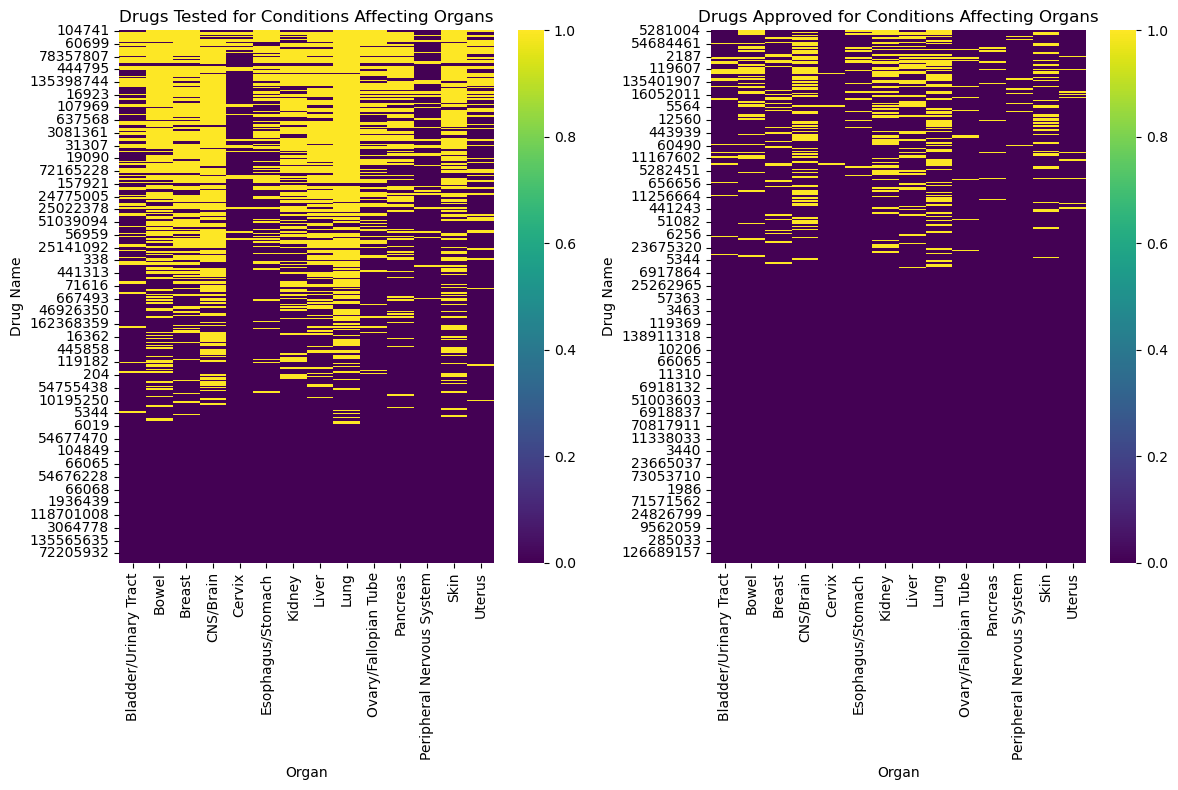

In [130]:
# Create a figure with 2 subplots in 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot the tested drugs heatmap in the first subplot
sns.heatmap(tested_df, ax=axes[0], cmap='viridis')
axes[0].set_title('Drugs Tested for Conditions Affecting Organs')
axes[0].set_ylabel('Drug Name')
axes[0].set_xlabel('Organ')

# Plot the successful drugs heatmap in the second subplot
sns.heatmap(success_df, ax=axes[1], cmap='viridis')
axes[1].set_title('Drugs Approved for Conditions Affecting Organs')
axes[1].set_ylabel('Drug Name')
axes[1].set_xlabel('Organ')

# Adjust layout and display
plt.tight_layout()
plt.show()

## To check one entry

In [63]:
import requests
import json
import time

def examine_study_structure(pubchem_id):
    """
    Examine the full field structure for clinical trials related to a drug with given PubChem ID
    """
    print(f"Examining study structure for PubChem ID: {pubchem_id}")
    
    # Get drug name from PubChem
    pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    synonyms_url = f"{pubchem_base_url}/compound/cid/{pubchem_id}/synonyms/JSON"
    
    try:
        synonyms_response = requests.get(synonyms_url)
        if synonyms_response.status_code != 200:
            print(f"Error retrieving synonyms: {synonyms_response.status_code}")
            return
            
        synonyms_data = synonyms_response.json()
        synonyms = synonyms_data.get("InformationList", {}).get("Information", [{}])[0].get("Synonym", [])
        
        # Try to find a short, drug-like name
        drug_name = None
        for syn in sorted(synonyms, key=len):
            if 3 < len(syn) < 20 and syn[0].isupper() and syn.isalpha():
                drug_name = syn
                break
                
        if not drug_name and synonyms:
            drug_name = synonyms[0]
            
        print(f"Using drug name: {drug_name}")
            
        # Search clinical trials
        clinicaltrials_api_url = "https://clinicaltrials.gov/api/v2/studies"
        params = {
            "query.term": drug_name,
            "pageSize": 1  # Just get one study to examine structure
        }
        
        response = requests.get(clinicaltrials_api_url, params=params)
        
        if response.status_code != 200:
            print(f"Error searching ClinicalTrials.gov: {response.status_code}")
            return
            
        data = response.json()
        studies = data.get("studies", [])
        
        if not studies:
            print("No studies found")
            return
            
        # Print the structure of the first study
        study = studies[0]
        
        # Print key paths
        protocol = study.get("protocolSection", {})
        
        print("\nStudy ID:")
        print(protocol.get("identificationModule", {}).get("nctId", "Not found"))
        
        print("\nPhase Module Structure:")
        print(json.dumps(protocol.get("phaseModule", {}), indent=2))
        
        print("\nFull Protocol Section Structure (keys only):")
        print_nested_keys(protocol)
        
        # Optionally dump the full structure to a file for detailed examination
        with open(f"study_structure_{pubchem_id}.json", "w") as f:
            json.dump(study, f, indent=2)
        print(f"\nFull structure saved to study_structure_{pubchem_id}.json")
        
    except Exception as e:
        print(f"Error examining study structure: {e}")
        
def print_nested_keys(obj, prefix=""):
    """Print the keys of a nested dictionary with indentation"""
    if isinstance(obj, dict):
        for key in obj.keys():
            print(f"{prefix}{key}")
            if isinstance(obj[key], (dict, list)) and obj[key]:
                print_nested_keys(obj[key], prefix + "  ")
    elif isinstance(obj, list) and obj:
        print(f"{prefix}[list with {len(obj)} items]")
        if len(obj) > 0 and isinstance(obj[0], dict):
            print_nested_keys(obj[0], prefix + "  ")

# Example usage
pubchem_id = "165411828"  # Ixazomib
examine_study_structure(pubchem_id)

Examining study structure for PubChem ID: 165411828
Using drug name: STERITALC

Study ID:
NCT04010565

Phase Module Structure:
{}

Full Protocol Section Structure (keys only):
identificationModule
  nctId
  orgStudyIdInfo
    id
  organization
    fullName
    class
  briefTitle
  officialTitle
  acronym
statusModule
  statusVerifiedDate
  overallStatus
  expandedAccessInfo
    hasExpandedAccess
  startDateStruct
    date
    type
  primaryCompletionDateStruct
    date
    type
  completionDateStruct
    date
    type
  studyFirstSubmitDate
  studyFirstSubmitQcDate
  studyFirstPostDateStruct
    date
    type
  lastUpdateSubmitDate
  lastUpdatePostDateStruct
    date
    type
sponsorCollaboratorsModule
  responsibleParty
    type
  leadSponsor
    name
    class
  collaborators
    [list with 4 items]
      name
      class
oversightModule
  isFdaRegulatedDrug
  isFdaRegulatedDevice
descriptionModule
  briefSummary
  detailedDescription
conditionsModule
  conditions
    [list with 1 it